<a href="https://colab.research.google.com/github/Ephraimosse9/Pytorch-course-on-UDEMY--Notes-and-Codes/blob/main/Classifying_Food101_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import requests
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
!pip install torchmetrics
from torchmetrics import Accuracy
from torchmetrics import ConfusionMatrix
import mlxtend
from mlxtend.plotting import plot_confusion_matrix
import zipfile

In [2]:
import torch
import numpy as np
import random

torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [3]:
# torch.cuda.manual_seed(42)
# torch.manual_seed(42)
data_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    # transforms.RandomRotation(degrees=15), # Add random rotation
    # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), # Add color jitter
    # transforms.RandomPerspective(distortion_scale=0.2, p=0.5), # Add random perspective
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
)

test_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:

train_data = datasets.Food101(
    root="food",
    split="train",
    download=True,
    transform= data_transforms
)

test_data = datasets.Food101(
    root="food",
    split="test", # Use the test split for the test data
    download=True,
    transform= test_transform
)

In [5]:
class_names= test_data.classes
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [6]:

train_dataloader = DataLoader(
    dataset= train_data,
    batch_size= 254,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset= test_data,
    batch_size= 254,
    shuffle=False
)

In [7]:
len(train_dataloader), len(test_dataloader)

(299, 100)

In [8]:
from torch import nn
device= "cuda" if torch.cuda.is_available() else "cpu"

class FoodModel(nn.Module):
  def __init__(self, input_channels, hidden_units, output_shape):
    super().__init__()
    self.conv1_block = nn.Sequential(
        nn.Conv2d(in_channels=input_channels, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv2_block = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=131072, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape)
    )

  def forward(self, x):
    return self.classifier(self.conv2_block(self.conv1_block(x)))

model = FoodModel(input_channels=3, hidden_units=512, output_shape=101).to(device)

In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)
accuracy_fn = Accuracy(task="multiclass", num_classes=101).to(device)

In [10]:
def training_step(model, dataloader, loss_fn, optimizer, accuracy_fn):
  train_loss, train_acc = 0,0
  for X, y in dataloader:
    model.train()
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    accuracy = accuracy_fn(y_pred.argmax(dim=1), y)
    train_loss += loss
    train_acc += accuracy

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc

In [11]:
def evaluation_step(model, dataloader, loss_fn, accuracy_fn):
  test_loss, test_acc = 0,0
  model.eval()
  with torch.inference_mode():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      loss = loss_fn(y_pred, y)
      accuracy = accuracy_fn(y_pred.argmax(dim=1), y)
      test_loss += loss
      test_acc += accuracy

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  return test_loss, test_acc

In [12]:
from tqdm.auto import tqdm
epochs = 3 # Increase epochs
train_loss_list = []
test_loss_list = []
epoch_list = []

for epoch in tqdm(range(epochs)):
  train_loss, train_acc = training_step(model=model, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn)
  test_loss, test_acc = evaluation_step(model=model, dataloader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn)

  train_loss_list.append(train_loss)
  test_loss_list.append(test_loss)
  epoch_list.append(epoch)

  if epoch%10 ==0:
    print(f"Epoch: {epoch} || Training Loss: {train_loss: .2f}, Training_Accuracy: {train_acc*100: .2f}% || Testing Loss: {test_loss: .2f}, Testing Accuracy: {test_acc*100: .2f}%")

  0%|          | 0/3 [00:00<?, ?it/s]

KeyboardInterrupt: 

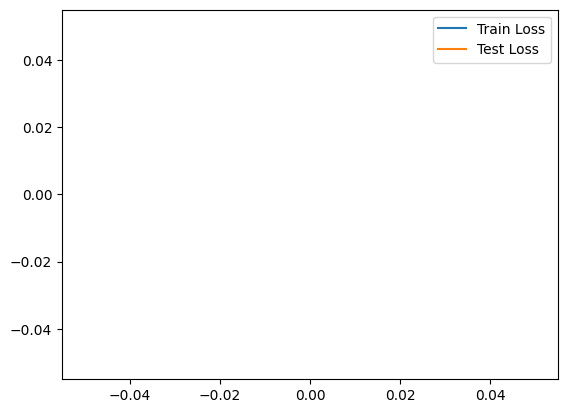

In [13]:
train_loss_list = np.array(torch.tensor(train_loss_list).numpy())
test_loss_list = np.array(torch.tensor(test_loss_list).numpy())


plt.plot(epoch_list, train_loss_list, label= "Train Loss")
plt.plot(epoch_list, test_loss_list, label= "Test Loss")


plt.legend()
